# <center> Линейная алгебра в контексте линейных методов. Практика.

## <center> Прогнозирование выработки газа на скважинах.

## Постановка задачи

У Василия, основателя компании «Газ-Таз-Ваз-Нефть», дела идут в гору: у него уже функционирует 200 скважин для добычи газа. В этом году он открывает 30 новых скважин. Однако в целях оптимизации расходов и повышения дохода Василию необходимо оценить, сколько денег будет приносить ему каждая из скважин, а также понять, какие факторы (параметры скважин) потенциально сильнее всего повлияют на объём добычи газа. Для этого Василий решил нанять вас как специалиста в области Data Science.

Василий представляет вам набор данных о добыче газа на своих скважинах. Файл с данными вы можете скачать на платформе.

**Признаки в данных:**

* Well — идентификатор скважины;
* Por — пористость скважины (%);
* Perm — проницаемость скважины;
* AI — акустический импеданс ($кг/м^2 * 10^6$);
* Brittle — коэффициент хрупкости скважины (%);
* TOC — общий органический углерод (%);
* VR — коэффициент отражения витринита (%);
* Prod — добыча газа в сутки (млн. кубических футов).

**Ваша задача** — построить регрессионную модель, которая прогнозирует выработку газа на скважине (целевой признак — Prod) на основе остальных характеристик скважины, и проинтерпретировать результаты вашей модели.

Разделим задачу на две части:
* В первой мы построим простейшую модель линейной регрессии, проанализируем результаты её работы и выберем наиболее значимые факторы для прогнозирования.
* Во второй мы займёмся построением модели полиномиальной регрессии с регуляризацией и посмотрим на итоговые результаты моделирования.


Импортируем необходимые библиотеки:

In [1]:
# Импорт библиотек
import numpy as np # для работы с массивами
import pandas as pd # для работы с DataFrame 
import seaborn as sns # библиотека для визуализации статистических данных
import matplotlib.pyplot as plt # для построения графиков

%matplotlib inline

Прочитаем исходные данные:

In [2]:
data = pd.read_csv('data/unconv.csv')
data.head()

,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
0,1,12.08,2.92,2.80,81.40,1.16,2.31,4165.196191
1,2,12.38,3.53,3.22,46.17,0.89,1.88,3561.146205
2,3,14.02,2.59,4.01,72.80,0.89,2.72,4284.348574
3,4,17.67,6.75,2.63,39.81,1.08,1.88,5098.680869
4,5,17.52,4.57,3.18,10.94,1.51,1.90,3406.132832


## Практика: линейная регрессия по методу наименьших квадратов

Для начала построим простейшую модель линейной регрессии, проанализируем результаты её работы и выберем наиболее значимые факторы для прогнозирования.

В первой части вам предстоит выполнить задания 5.0–5.6. Максимальное количество баллов, которое можно получить, — 9.

### Задание 5.0. (не оценивается)

Проведите небольшой разведывательный анализ, чтобы поближе познакомиться с исходными данными. Постройте несколько визуализаций, которые помогут вам понять, как устроены исходные признаки, а также смогут продемонстрировать взаимосвязь факторов. 

Сделайте промежуточные выводы из проведённого разведывательного анализа.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Well     200 non-null    int64  
 1   Por      200 non-null    float64
 2   Perm     200 non-null    float64
 3   AI       200 non-null    float64
 4   Brittle  200 non-null    float64
 5   TOC      200 non-null    float64
 6   VR       200 non-null    float64
 7   Prod     200 non-null    float64
dtypes: float64(7), int64(1)
memory usage: 12.6 KB


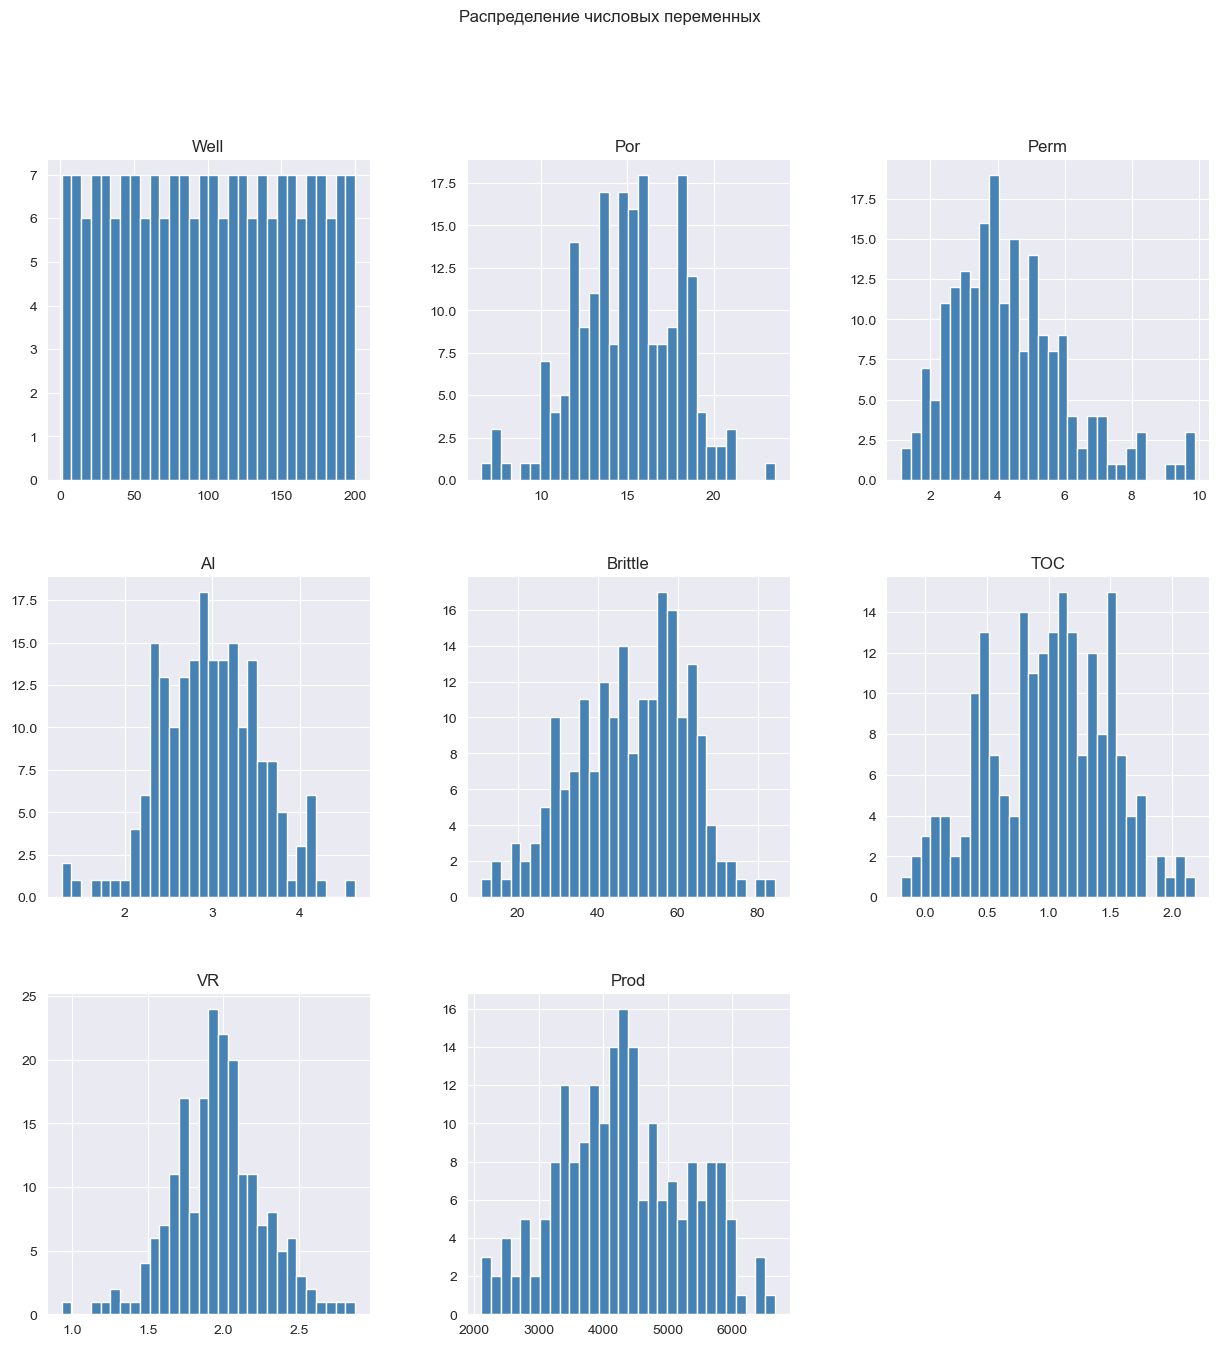

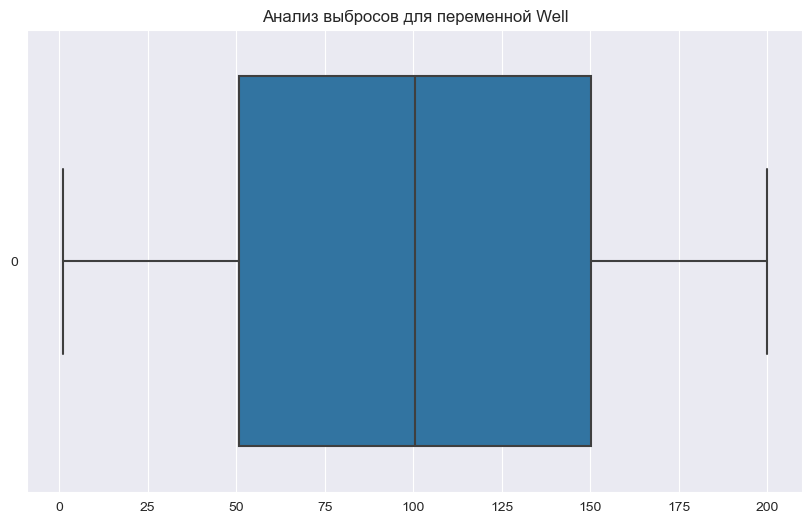

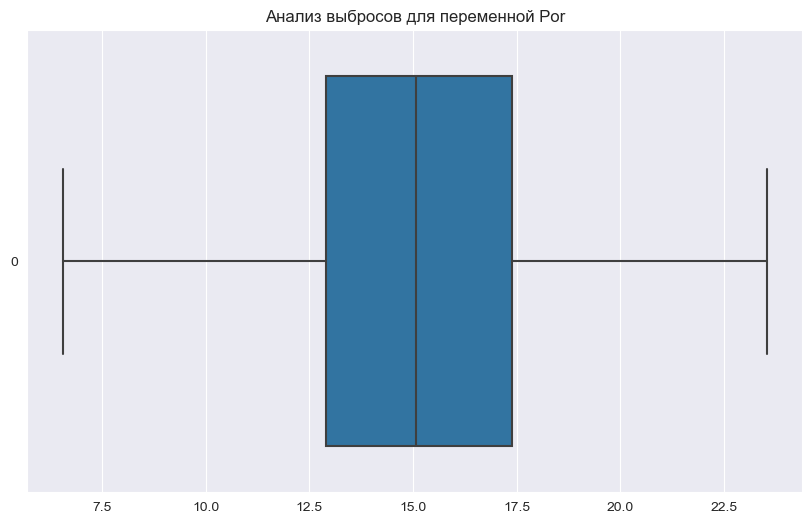

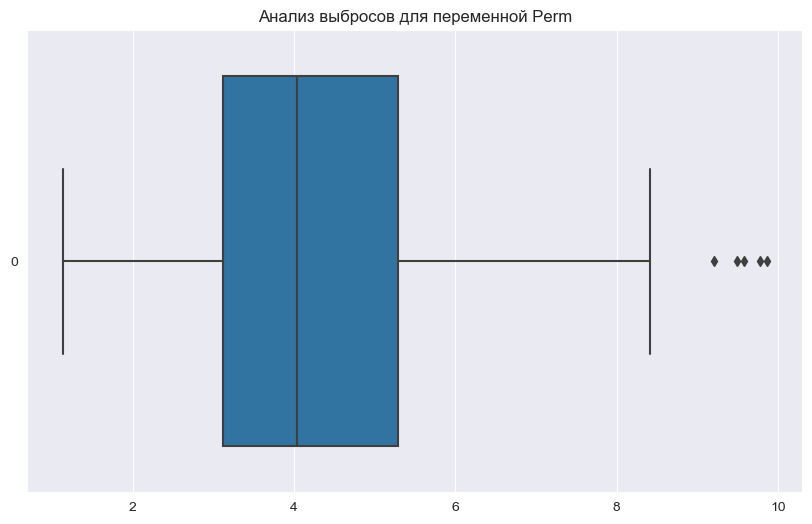

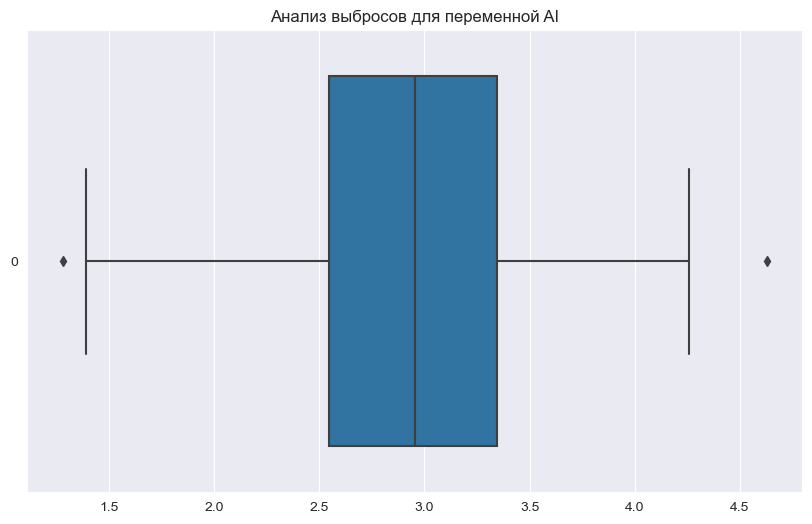

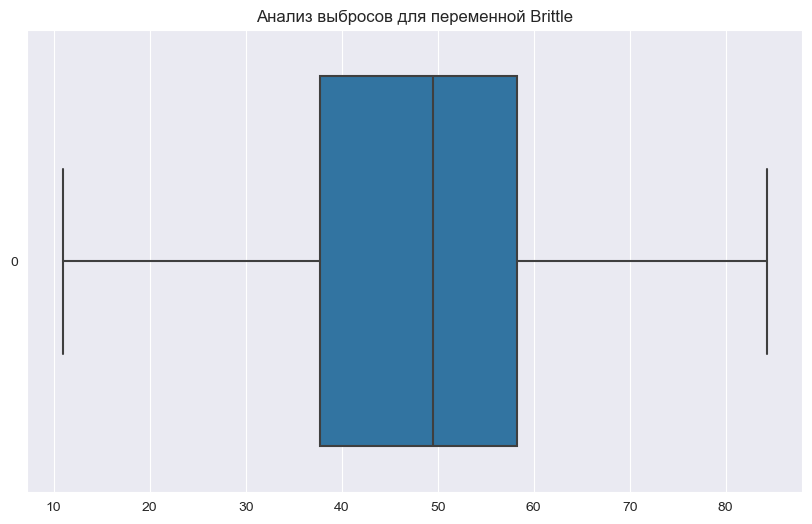

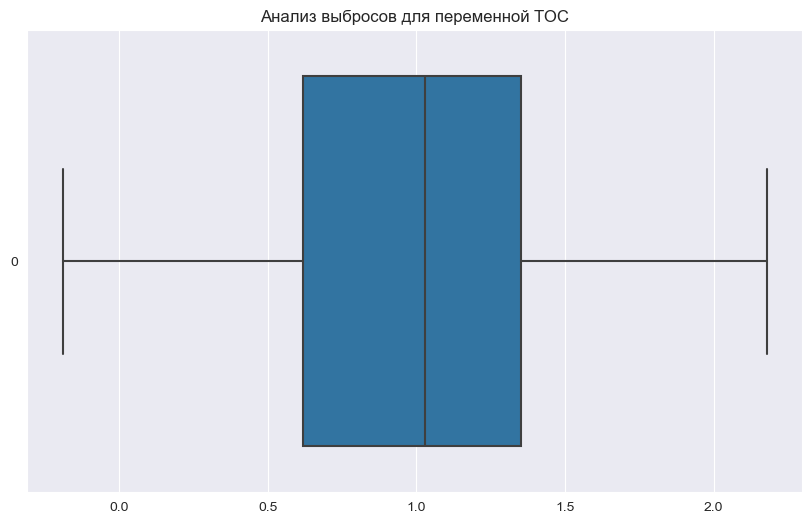

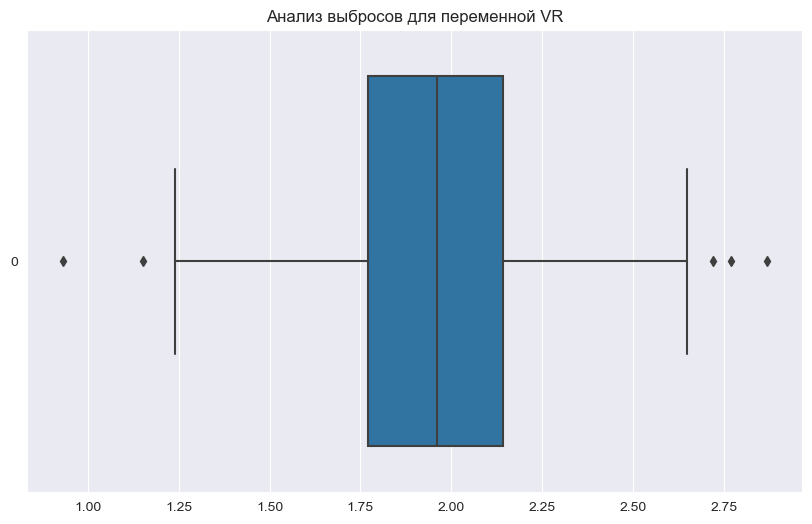

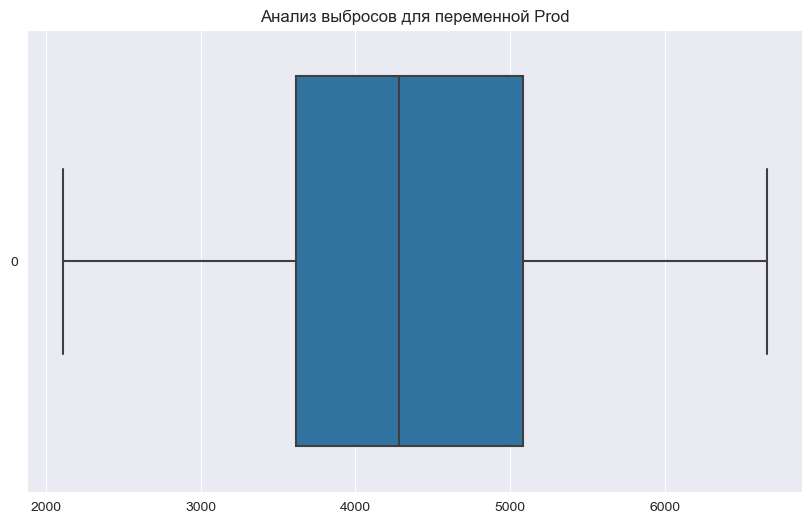

In [3]:
data.info()
data.describe()
data.hist(bins=30, figsize=(15, 15), color='steelblue')
plt.suptitle('Распределение числовых переменных')
plt.show()

# Проведём анализ выбросов во всех числовых переменных
def analyze_outliers(df):
    # Отбираем только числовые столбцы
    numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
    
    # Построение boxplot для каждого числового столбца
    for column in numeric_columns:
        plt.figure(figsize=(10, 6))
        sns.boxplot(data=df[column], orient='h')
        plt.title(f'Анализ выбросов для переменной {column}')
        plt.show()
        
# Анализ выбросов для всех числовых переменных
analyze_outliers(data)

# Промежуточные выводы
# Все параметры (Well не считаем) близки к нормальному распределению, включая наш целевой показатель Prod
# У Perm, AI и VR есть выбросы


### Задание 5.1. (2 балла)

Постройте корреляционную матрицу факторов, включив в неё целевой признак. 

Для наглядности визуализируйте полученную матрицу с помощью тепловой карты. 

**Примечание.** *Для визуализации вы можете использовать любую из знакомых вам библиотек.*

На основе построенной корреляционной матрицы ответьте на следующий вопрос:

* Какие факторы сильнее всего коррелируют с целевой переменной?

Вычислите ранг и определитель полученной матрицы корреляций и приведите развёрнутые ответы на следующие вопросы:
* Является ли корреляционная матрица плохо обусловенной (близок ли её опредитель к нулю)?
* Что вы можете сказать о наличии коллинераности/мультиколлинеарности в данных? 
* Применима ли в данном случае модель классической линейной регрессии по методу наименьших квадратов и почему? 

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для расчёта корреляционной матрицы;
    * приведён код для визуализации корреляционной матрицы в виде тепловой карты;
    * рассчитаны ранг и определитель корреляционной матрицы;
    * предоставлены обоснованные ответы на все поставленные вопросы. 

- Задание выполнено верно, но не учтено одно условие (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

ранг матрицы: 8
определитель матрицы: 0.000729938807265194


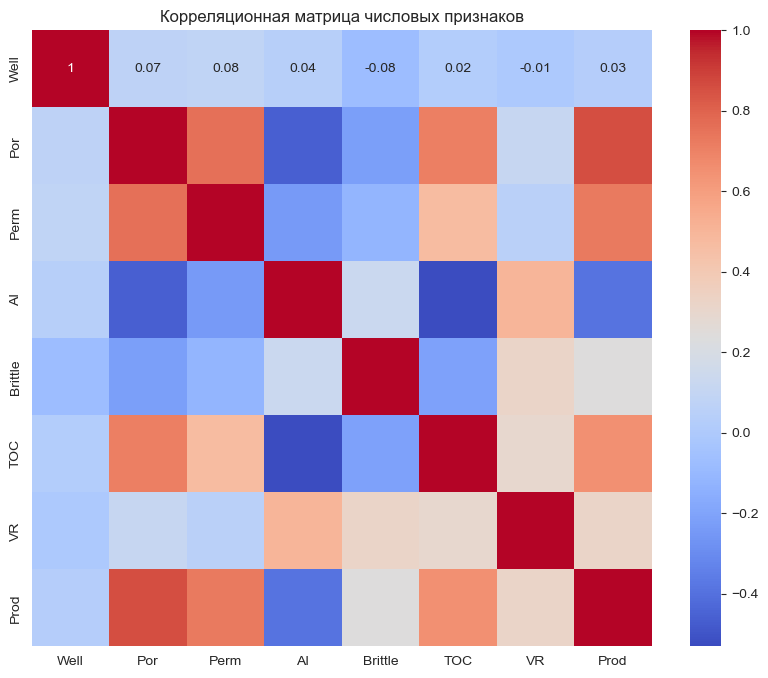

In [82]:
arr = data.to_numpy()

# Центрирование данных
mean = np.mean(arr, axis=0)
data_centered = arr - mean

# Вычисляем ковариационную матрицу
n_samples = arr.shape[0]
cov_matrix = np.dot(data_centered.T, data_centered) / (n_samples - 1)

# Вычисляем корреляционную матрицу
std_dev = np.std(arr, axis=0, ddof=1)
std_matrix = np.outer(std_dev, std_dev)
corr = cov_matrix / std_matrix

styled_corr = pd.DataFrame(corr).round(2).style.background_gradient(cmap='RdYlGn')
styled_corr.to_html('styled_corr.html')

rank = np.linalg.matrix_rank(corr)
print(f'ранг матрицы: {rank}')

determinant = np.linalg.det(corr)
print(f'определитель матрицы: {determinant}')

# Сверим нашу корреляционную матрицу с автоматически посчитанной
corr_auto = data.corr(numeric_only=True).round(2)
styled_corr_auto = corr_auto.style.background_gradient(cmap='RdYlGn')
styled_corr_auto.to_html('styled_corr_auto.html')

plt.figure(figsize=(10, 8))
sns.heatmap(corr_auto, annot=True, cmap='coolwarm')
plt.title('Корреляционная матрица числовых признаков')
plt.show()


### Выводы по матрице коллеряции

- Корреляционная матрица является плохо обусловенной, поскольку её опредитель близок к нулю. То есть матрица почти вырожденная.
- Мультиколлинеарность наблюдается у признаков: Por и Perm (0,76), Por и TOC (0,71)

Применение линейной регрессии методом наименьших квадратов не рекомендуется в ситуации с сильной мультиколлинеарностью и малым определителем матрицы признаков, поскольку это приведет к нестабильности оценок коэффициентов и низкой точности модели.

При построении линейной регрессии методом наименьших квадратов необходимо вычислять обратную матрицу. 
Если определитель матрицы близок к нулю, матрица почти вырожденная, и ее обратная матрица либо не существует, либо вычисляется с большой ошибкой. 
И вычисления становятся ненадежными из-за ошибок округления.

Последствия мультиколлинеарности:
- Нестабильность оценок коэффициентов: Коэффициенты становятся чувствительными к небольшим изменениям в данных.
- Высокие стандартные ошибки: Это приводит к снижению статистической значимости коэффициентов.
- Трудности в интерпретации модели: Трудно определить влияние отдельных признаков на целевую переменную.

Корреляция с Prod: Por и Perm сильная (более 0,73), TOC умеренная (0,65), AI умеренная отрицательная (-0,39)

### Задание 5.2. (2 балла)

Создайте матрицу наблюдений `X` и вектор правильных ответов `y`. В качестве факторов для матрицы наблюдений возьмите все имеющиеся в данных признаки. 

Постройте модель линейной регрессии по методу наименьших квадратов. Для этого воспользуйтесь матричной формулой МНК и инструментарием библиотеки numpy. 

Выведите на экран полученные оценки коэффициентов модели, округлённые до целого.

Приведите подробные выводы по полученным результатам, ответив на следующие вопросы:
* Есть ли в ваших данных признаки, которые, согласно модели, можно назвать неинформативными, то есть они не оказывают влияния на целевую переменную или оказывают шумовое влияние?
* Приведите интерпретацию нескольких (двух или трёх) коэффициентов полученной модели линейной регрессии.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для нахождения параметров модели линейной регрессии с помощью матричной формулы МНК;
    * на основе полученных параметров даны верные ответы на поставленные вопросы;
    * приведена корректная интерпретация нескольких коэффициентов полученной модели линейной регрессии.

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [34]:
arr = data.drop(columns=['Prod']).to_numpy()
A = np.hstack((np.ones((arr.shape[0], 1)), arr))
y = data[['Prod']]
# вычислим OLS-оценку для коэффициентов
w_hat = np.linalg.inv(A.T @ A) @ A.T @ y
w_hat_rounded = np.round(w_hat)
print(w_hat_rounded)

     Prod
0 -1232.0
1     0.0
2   230.0
3   116.0
4  -365.0
5    25.0
6   -78.0
7   785.0


## Выводы по коэффициентам линейной регрессии
- 0 индекс - это свободный член или интерсепт, и задает базовый уровень целевого признака (ЦП)
- признак с индексом 1 не влияет на ЦП и является неинформативными
- с признаками 2,3,5,7 существует прямая зависимость с ЦП
- с признаками 4,6 существует обратная зависимость с ЦП
- признаки 3,5 и 6 возможно оказывают шумовое влияние на ЦП, но точно можно будет сказать только после нормирования признаков. 

Какой признак больше влияет на ЦП пока сказать сложно, поскольку мы не нормировали значения самих признаков

### Задание 5.3. (1 балл)

Теперь потренируемся строить предсказание для наблюдений целевой переменной. 

**а)** Постройте прогноз выработки газа для скважины со следующими параметрами:

```python
{
    'Well': 106.0,
    'Por': 15.32,
    'Perm': 3.71,
    'AI': 3.29,
    'Brittle': 55.99,
    'TOC': 1.35,
    'VR': 2.42
 }
```

Рассчитайте абсолютную ошибку построенного вами прогноза для предложенной скважины (в миллионах кубических футов в день), если известно, что на этой скважине производится `4748.315024` миллионов кубических футов газа в день. 

**б)** Постройте прогноз выработки газа для всех скважин из обучающего набора данных. Выберите метрику, по которой вы будете оценивать качество регрессионных моделей и сравнивать их между собой (можно использовать несколько метрик, но не более двух).

Рассчитайте значение выбранной метрики для вашей модели. Приведите интерпретацию полученного результата. 

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * приведён код для построения прогноза выработки газа на указанной скважине и рассчитана абсолютная ошибка прогноза для этой скважины;
    * выбрана корректная для поставленной задачи метрика (или метрики) оценки качества модели и приведён код для расчёта этой метрики на всём обучающем наборе данных;
    * приведена корректная интерпретация полученного результата.

- Задание выполнено верно, но не учтено одно из условий, или задание выполнено неверно (**0 баллов**).

In [51]:
# Рассчитаем прогнозное значение для новой скважины
new_arr = np.array(list({
    'Well': 106.0,
    'Por': 15.32,
    'Perm': 3.71,
    'AI': 3.29,
    'Brittle': 55.99,
    'TOC': 1.35,
    'VR': 2.42
 }.values())) 
new_A = np.hstack(([1], new_arr))
y_pred = new_A @ w_hat_rounded
print(f'a) y_pred = {y_pred.tolist()[0]}')

# Рассчитаем абсолютную ошибку (AE) при y_true = 4748.315024
y_true = 4748.315024
ae = np.abs(y_pred - y_true)
print(f'a) AE = {np.round(ae.tolist()[0])}')

# Рассчитаем прогнозные значения для всех скважин из тренировочного набора
y_pred = A @ w_hat

# Для оценки качества регрессионной модели возьмём 2 метрики: среднюю абсолютную ошибку (MAE) и корень среднеквадратической ошибки (RMSE)
y_true = y
mae = np.mean(np.abs(y_pred - y_true))
print(f'б) MAE = {np.round(mae)}')

mse = np.mean((y_pred - y_true) ** 2)
rmse = np.sqrt(mse)
print(f'б) RMSE = {np.round(rmse)}')

# Найдём разницу между RMSE и MAE поскольку у них одинаковые единицы измерения, что удобно для интерпретации
print(f'б) RMSE - MAE = {np.round(rmse - mae)}')
y_true_mean = np.round(np.mean(y_true))
print(f'б) Среднее значение реального целевого признака = {y_true_mean}')
print(f'б) Отклонение MAE в % от среднего значения реального целевого признака = {np.round(mae / y_true_mean * 100)}')
print(f'б) Отклонение RMSE в % от среднего значения реального целевого признака = {np.round(rmse / y_true_mean * 100)}')

a) y_pred = 4715.26
a) AE = 33.0
б) MAE = 154.0
б) RMSE = 198.0
б) RMSE - MAE = 45.0
б) Среднее значение реального целевого признака = 4311.0
б) Отклонение MAE в % от среднего значения реального целевого признака = 4.0
б) Отклонение RMSE в % от среднего значения реального целевого признака = 5.0


## Интерпретация полученного результата

RMSE использовать для оценки предпочтительнее, если:
- если важно сильно штрафовать большие ошибки
- если ошибки имеют нормальное распределение
- когда модель должна быть более точной в предсказании больших значений отклонения

MAE использовать для оценки предпочтительнее, если:
- если данные содержат выбросы, и вы не хотите, чтобы они сильно влияли на оценку модели
- если важна средняя ошибка без акцента на большие отклонения
- когда распределение ошибок является не нормальным

В нашей модели MAE и RMSE находятся в диапозоне 5% от среднего значения реального целевого признака,<br>
что можно считать достаточно точной моделью предсказания для наших тренировочных целей.

RMSE больше MAE на 45 единиц, поскольку в данных присутствуют выбросы, к которым метрики MSE и RMSE более чувствительны, чем MAE

### Задание 5.4. (1 балл)

Настало время анализа построенной модели. Посмотрите на коэффициенты и сравните их знаки со значениями выборочных корреляций между целевым признаком и факторами, которые вы нашли ранее.

Дайте развёрнутые ответы на следующие вопросы:

* Есть ли в вашей модели фактор, при котором коэффициент в модели линейной регрессии противоречит соответствующему коэффициенту корреляции? Например, корреляция говорит, что зависимость между фактором и целевой переменной прямая, а модель говорит обратное. Если таких факторов несколько, укажите их все.
* Как вы считаете, с чем связано полученное противоречие результатов?

**Критерии оценивания:**

- Задание выполнено верно, даны корректные развёрнутые ответы на все поставленные в задании вопросы (**1 балл**). 

- Задание выполнено неверно, даны некорректные ответы на один или несколько поставленных в задании вопросов (**0 баллов**).

In [83]:
w_corr = corr_auto[['Prod']]
w_corr = w_corr.shift(periods=1)
corr_y = np.hstack((w_hat_rounded, w_corr))
corr_y

array([[-1.232e+03,        nan],
       [ 0.000e+00,  3.000e-02],
       [ 2.300e+02,  8.600e-01],
       [ 1.160e+02,  7.300e-01],
       [-3.650e+02, -3.900e-01],
       [ 2.500e+01,  2.400e-01],
       [-7.800e+01,  6.500e-01],
       [ 7.850e+02,  3.200e-01]])

## Выводы по сравнению корреляции признаков и найденными весами

Под индексом 0 указан интерсепт, который отсутствует в корреляционной матрице, поэтому его сравнивать не будем.

Признак под индексом 6 (наименование TOC) — единственный, где наблюдается противоречие: коэффициент линейной регрессии отрицательный, а корреляция положительная.

Предположу, что поскольку TOC мультиколлинеарен с Por, а Por имеет большее влияние на целевой признак (0,86 против 0,65), <br>
то коэффициент признака Por сильно перекрывает своим влиянием признак TOC, снижая коэффициент последнего до отрицательного значения.



### Задание 5.5. (2 балла)

* Исключите из данных сильно коррелированные между собой факторы. Под сильной корреляцией в данной задаче будем понимать значения выше `0.7`.

Выбирая, какой из коррелированных факторов оставить, руководствуйтесь коэффициентом корреляции с целевой переменной: оставляйте тот фактор, который больше всего коррелирует с целевой переменной (объёмом добычи газа).

* Также исключите из данных факторы, для которых корреляция с целевой переменной меньше `0.05`.

Постройте модель линейной регрессии на обновлённых после удаления факторов данных по методу наименьших квадратов. Для этого используйте матричную формулу и библиотеку numpy. Выведите значение полученных коэффициентов, округлённых до целого.

Сделайте прогноз для всего обучающего набора данных и рассчитайте выбранную вами ранее метрику (или метрики). 

Дайте подробные ответы на следующие вопросы:

* Приведите интерпретацию нескольких полученных коэффициентов (двух или трёх). Сравните их значения с полученными ранее.
* Приведите интерпретацию полученных значений метрик. Сравните их значения с полученными ранее. 
* Удалось ли вам побороть противоречие коэффициентов линейной регрессии и коэффициентов корреляции?

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * отобраны верные факторы;
    * на основе отобранных факторов построена модель линейной регрессии с помощью матричной формулы МНК и найдены параметры модели, соответствующие каждому из факторов;
    * построен прогноз для всего обучающего набора данных и рассчитано значение метрики (метрика должна быть выбрана корректно);
    * даны ответы на все поставленные в задании вопросы.

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено верно, не учтено несколько из условий (**0 баллов**).

In [86]:
# Мультиколлинеарность наблюдается у признаков: Por и Perm (0,76), Por и TOC (0,71)
# В обоих случаях Por имеет большее влияние на целевой признак, поэтому удалим Perm и TOC
# Также удалим Well, поскольку его корреляция с целевым признаком меньше 0,05
arr = data.drop(columns=['Perm', 'TOC', 'Well', 'Prod']).to_numpy()
A = np.hstack((np.ones((arr.shape[0], 1)), arr))
y = data[['Prod']]
# вычислим OLS-оценку для коэффициентов
w_hat = np.linalg.inv(A.T @ A) @ A.T @ y
w_hat_rounded = np.round(w_hat)
print(w_hat_rounded)

# Рассчитаем прогнозные значения для всех скважин из тренировочного набора
y_pred = A @ w_hat

# Для оценки качества регрессионной модели возьмём 2 метрики: среднюю абсолютную ошибку (MAE) и корень среднеквадратической ошибки (RMSE)
y_true = y
mae = np.mean(np.abs(y_pred - y_true))
print(f'MAE = {np.round(mae)}')

mse = np.mean((y_pred - y_true) ** 2)
rmse = np.sqrt(mse)
print(f'RMSE = {np.round(rmse)}')

# Найдём разницу между RMSE и MAE поскольку у них одинаковые единицы измерения, что удобно для интерпретации
print(f'RMSE - MAE = {np.round(rmse - mae)}')
y_true_mean = np.round(np.mean(y_true))
print(f'Среднее значение реального целевого признака = {y_true_mean}')
print(f'Отклонение MAE в % от среднего значения реального целевого признака = {np.round(mae / y_true_mean * 100)}')
print(f'Отклонение RMSE в % от среднего значения реального целевого признака = {np.round(rmse / y_true_mean * 100)}')

w_corr = corr_auto.drop(['Perm', 'TOC', 'Well'])[['Prod']]
w_corr = w_corr.shift(periods=1)
corr_y = np.hstack((w_hat_rounded, w_corr))
corr_y

     Prod
0 -1835.0
1   293.0
2  -200.0
3    28.0
4   517.0
MAE = 171.0
RMSE = 232.0
RMSE - MAE = 60.0
Среднее значение реального целевого признака = 4311.0
Отклонение MAE в % от среднего значения реального целевого признака = 4.0
Отклонение RMSE в % от среднего значения реального целевого признака = 5.0


array([[-1.835e+03,        nan],
       [ 2.930e+02,  8.600e-01],
       [-2.000e+02, -3.900e-01],
       [ 2.800e+01,  2.400e-01],
       [ 5.170e+02,  3.200e-01]])

## Выводы по сравнению корреляции признаков и найденными весами
- После удаления факторов Perm, TOC и Well, коэффициенты линейной регрессии стали более стабильными и интерпретируемыми и их суммарный вес уменьшился (интерсепт не считаем), что говорит о том, что модель стала более устойчивой.
- Признаки с индексами 1, 3, 4 имеют прямую зависимость с целевым признаком, что соответствует корреляции.
- Признак с индексом 2 имеет обратную зависимость с целевым признаком, что соответствует корреляции.
- Противоречие между коэффициентами линейной регрессии и коэффициентами корреляции было устранено
- Хоть RMSE и MAE увеличились после удаления факторов, но они все равно находятся в диапозоне 5% от среднего значения реального целевого признака, что можно считать достаточно точной моделью предсказания для наших тренировочных целей.
- Увеличение MAE и RMSE после удаления факторов связано с тем, что мы удалили факторы, которые могли улучшить предсказательную способность модели, но при этом они были сильно коррелированы с другими факторами, что приводило к мультиколлинеарности и нестабильности оценок коэффициентов.

### Задание 5.6. (1 балл)

Наконец, давайте построим модель линейной регрессии из библиотеки `scikit-learn (sklearn)` и сравним результаты её работы с теми, что нам удалось получить вручную. 

Постройте модель линейной регрессии на обновлённых после удаления факторов данных по методу наименьших квадратов. Для этого воспользуйтесь классом `LinearRegression` из библиотеки `sklearn`. Выведите значения полученных коэффициентов, округлённые до целого.

Сделайте прогноз для всего обучающего набора данных и рассчитайте значение выбранной вами метрики (или метрик).

Сравните результаты библиотечной реализации с тем, что вы получили ранее. 

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * на основе отобранных факторов построена модель линейной регрессии из библиотеки sklearn и найдены параметры модели, соответствующие каждому из факторов;
    * построен прогноз для всего обучающего набора данных и рассчитано значение метрики (метрика должна быть выбрана корректно);
    * приведён вывод о соответствии результатов, полученных вручную и с помощью библиотеки.
- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [106]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

model = LinearRegression()
x_train = data.drop(columns=['Perm', 'TOC', 'Well', 'Prod'])
y_true = data[['Prod']]
model.fit(x_train, y_true)
y_pred = model.predict(x_train)

# Выведем коэффициенты модели
w_hat = np.hstack((model.intercept_, model.coef_[0]))
w_hat_rounded = np.round(w_hat)
print(w_hat_rounded)

# Для оценки качества регрессионной модели возьмём 2 метрики: среднюю абсолютную ошибку (MAE) и корень среднеквадратической ошибки (RMSE)
mae = mean_absolute_error(y_true, y_pred)
print(f'MAE = {np.round(mae)}')

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
print(f'RMSE = {np.round(rmse)}')



# Найдём разницу между RMSE и MAE поскольку у них одинаковые единицы измерения, что удобно для интерпретации
print(f'RMSE - MAE = {np.round(rmse - mae)}')
y_true_mean = np.round(np.mean(y_true))
print(f'Среднее значение реального целевого признака = {y_true_mean}')
print(f'Отклонение MAE в % от среднего значения реального целевого признака = {np.round(mae / y_true_mean * 100)}')
print(f'Отклонение RMSE в % от среднего значения реального целевого признака = {np.round(rmse / y_true_mean * 100)}')


# Для задания 8.5 возьмём ещё метрику MAPE
# Определяем словарь с метриками
scoring = {
    'MAE': 'neg_mean_absolute_error',
    'RMSE': 'neg_root_mean_squared_error',
    'MAPE': 'neg_mean_absolute_percentage_error'
}

# оцениваем качество модели на кросс-валидации
from sklearn.model_selection import cross_validate
cv_results = cross_validate(model, x_train, y_true, scoring=scoring, cv=5, return_train_score=True)


# Выводим результаты для MAE
print('MAE на тренировочных фолдах: {:.2f}'.format(-cv_results['train_MAE'].mean()))
print('MAE на валидационных фолдах: {:.2f}'.format(-cv_results['test_MAE'].mean()))

# Выводим результаты для RMSE
print('RMSE на тренировочных фолдах: {:.2f}'.format(-cv_results['train_RMSE'].mean()))
print('RMSE на валидационных фолдах: {:.2f}'.format(-cv_results['test_RMSE'].mean()))

# Выводим результаты для MAPE
print('MAPE на тренировочных фолдах: {:.2f} %'.format(-cv_results['train_MAPE'].mean()* 100))
print('MAPE на валидационных фолдах: {:.2f} %'.format(-cv_results['test_MAPE'].mean() * 100))

[-1835.   293.  -200.    28.   517.]
MAE = 171.0
RMSE = 232.0
RMSE - MAE = 60.0
Среднее значение реального целевого признака = 4311.0
Отклонение MAE в % от среднего значения реального целевого признака = 4.0
Отклонение RMSE в % от среднего значения реального целевого признака = 5.0
MAE на тренировочных фолдах: 170.50
MAE на валидационных фолдах: 179.02
RMSE на тренировочных фолдах: 230.36
RMSE на валидационных фолдах: 240.21
MAPE на тренировочных фолдах: 4.02 %
MAPE на валидационных фолдах: 4.23 %


## Выводы по сравнению результатов библиотечной и ручной реализации
- Результаты, полученные библиотечной реализацией, совпадают с результатами, полученными вручную, что говорит о корректности построения модели.
- Метрики MAE и RMSE, полученные библиотечной реализацией, также совпадают с результатами, полученными вручную, что говорит о корректности оценки качества модели.
- Библиотечная реализация позволяет построить модель линейной регрессии быстрее и удобнее, чем ручная реализация, поэтому в дальнейшем лучше использовать библиотечные инструменты для построения моделей.

## Практика: полиномиальная регрессия и регуляризация

Мы продолжаем работать над задачей от владельца компании «Газ-Таз-Ваз-Нефть» Василия.

Ранее мы построили модель линейной регрессии, которая прогнозирует выработку газа на скважине. Для этого мы с помощью матрицы корреляций и рассуждений отобрали некоррелированные, значимые для предсказания признаки. **Далее мы будем использовать именно их (см. задание 5.5).**

Мы хотим улучшить результат — уменьшить ошибку прогноза. Для этого мы воспользуемся моделью полиномиальной регрессии третьей степени. Однако теперь мы знаем, что полиномиальным моделям очень легко переобучиться под исходную выборку. Так как данных у нас не так много (всего 200 скважин), то для контроля качества модели мы будем использовать кросс-валидацию. 

Приступим! Выполните задания 8.1–8.5:


In [10]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

### Задание 8.1. (1 балл)

Стандаризируйте признаки с помощью `StandartScaler` из библиотеки `sklearn`. 

Затем сгенерируйте полиномиальные признаки третьего порядка на факторах, которые вы выбрали для обучения моделей. Для этого воспользуйтесь генератором полиномов `PolynomialFeatures` из библиотеки `sklearn`. Параметр `include_bias` установите в значение `False`.

Выведите на экран, сколько факторов у вас получилось после генерации полиномиальных признаков.

**Важно:** стандартизацию необходимо произвести до генерации полиномиальных факторов!

Обучите модель линейной регрессии из библиотеки `sklearn` (`LinearRegression`) на полученных полиномиальных факторах.

Используя кросс-валидацию оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * на основе отобранных факторов сгенерированы полиномиальные признаки третьего порядка;
    * построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).
- Задание выполнено неверно, не учтено одно или несколько из условий (**0 баллов**).

In [96]:
df = data

# Выбираем признаки и целевую переменную
X = df[['Por', 'AI', 'Brittle', 'VR']]
y = df['Prod']

# Инициализируем стандартизатор
scaler = StandardScaler()

# Стандартизируем признаки
X_scaled = scaler.fit_transform(X)

# Инициализируем генератор полиномиальных признаков
poly = PolynomialFeatures(degree=3, include_bias=False)

# Генерируем полиномиальные признаки
X = poly.fit_transform(X_scaled)

# Количество факторов после генерации полиномиальных признаков
n_features = X.shape[1]

print(f"Количество факторов после генерации полиномиальных признаков: {n_features}")

# Создаем модель линейной регрессии
lr = LinearRegression()

# Определяем словарь с метриками
scoring = {
    'MAE': 'neg_mean_absolute_error',
    'RMSE': 'neg_root_mean_squared_error',
    'MAPE': 'neg_mean_absolute_percentage_error'
}

# оцениваем качество модели на кросс-валидации
cv_results = cross_validate(lr, X, y, scoring=scoring, cv=5, return_train_score=True)


# Выводим результаты для MAE
print('MAE на тренировочных фолдах: {:.2f}'.format(-cv_results['train_MAE'].mean()))
print('MAE на валидационных фолдах: {:.2f}'.format(-cv_results['test_MAE'].mean()))

# Выводим результаты для RMSE
print('RMSE на тренировочных фолдах: {:.2f}'.format(-cv_results['train_RMSE'].mean()))
print('RMSE на валидационных фолдах: {:.2f}'.format(-cv_results['test_RMSE'].mean()))

# Выводим результаты для MAPE
print('MAPE на тренировочных фолдах: {:.2f} %'.format(-cv_results['train_MAPE'].mean()* 100))
print('MAPE на валидационных фолдах: {:.2f} %'.format(-cv_results['test_MAPE'].mean() * 100))	



Количество факторов после генерации полиномиальных признаков: 34
MAE на тренировочных фолдах: 75.35
MAE на валидационных фолдах: 110.47
RMSE на тренировочных фолдах: 100.74
RMSE на валидационных фолдах: 154.51
MAPE на тренировочных фолдах: 1.77 %
MAPE на валидационных фолдах: 2.68 %


## Выводы по построению модели полиномиальной регрессии
- После генерации полиномиальных признаков третьей степени у нас получилось 34 фактора.
- При сравнении метрик на тренировочных и валидационных фолдах видно, что модель переобучена, поскольку значения метрик на тренировочных фолдах немного лучше, чем на валидационных.
- MAE, RMSE стали намного лучше, чем при использовании линейной регрессии только на признаках 1-ой степени, что говорит о том, что модель стала более точной в предсказании целевого признака.
- Также стоит отметить, что модель полиномиальной регрессии третьей степени может быть сложной для интерпретации, поскольку включает в себя большое количество факторов.

### Задание 8.2. (2 балла)

Теперь попробуем воспользоваться линейной регрессией с регуляризацией. Для начала возьмём $L_1$-регуляризацию.

Обучите модель `Lasso` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициент регуляризации (`alpha`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию, оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (Lasso), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [109]:
df = data

# Выбираем признаки и целевую переменную
X = df[['Por', 'AI', 'Brittle', 'VR']]
y = df['Prod']

# Инициализируем стандартизатор
scaler = StandardScaler()

# Стандартизируем признаки
X_scaled = scaler.fit_transform(X)

# Инициализируем генератор полиномиальных признаков
poly = PolynomialFeatures(degree=3, include_bias=False)

# Генерируем полиномиальные признаки
X = poly.fit_transform(X_scaled)

# Создаём модель линейной регрессии c L1-регуляризацией
# Создаем модель Lasso без указания alpha
lasso = Lasso(max_iter=10000)

# Определяем диапазон значений alpha для перебора
alpha_range = np.logspace(-4, 1, 50)  # от 0.0001 до 10 (50 значений)

# Определяем сетку гиперпараметров
param_grid = {'alpha': alpha_range}

# Настраиваем GridSearchCV
grid_search = GridSearchCV(estimator=lasso, param_grid=param_grid, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

# Выполняем поиск по сетке
grid_search.fit(X, y)

# Получаем лучшее значение alpha
best_alpha = grid_search.best_params_['alpha']
print(f"Оптимальное значение alpha: {best_alpha:.5f}")

# Создаем модель Lasso с оптимальным alpha
lasso_best = Lasso(alpha=best_alpha, max_iter=10000)

# Определяем словарь с метриками
scoring = {
    'MAE': 'neg_mean_absolute_error',
    'RMSE': 'neg_root_mean_squared_error',
    'MAPE': 'neg_mean_absolute_percentage_error'
}

# оцениваем качество модели на кросс-валидации
cv_results = cross_validate(lasso_best, X, y, scoring=scoring, cv=5, return_train_score=True)


# Выводим результаты для MAE
print('MAE на тренировочных фолдах: {:.2f}'.format(-cv_results['train_MAE'].mean()))
print('MAE на валидационных фолдах: {:.2f}'.format(-cv_results['test_MAE'].mean()))

# Выводим результаты для RMSE
print('RMSE на тренировочных фолдах: {:.2f}'.format(-cv_results['train_RMSE'].mean()))
print('RMSE на валидационных фолдах: {:.2f}'.format(-cv_results['test_RMSE'].mean()))

# Выводим результаты для MAPE
print('MAPE на тренировочных фолдах: {:.2f} %'.format(-cv_results['train_MAPE'].mean()* 100))
print('MAPE на валидационных фолдах: {:.2f} %'.format(-cv_results['test_MAPE'].mean() * 100))	

Оптимальное значение alpha: 4.94171
MAE на тренировочных фолдах: 78.26
MAE на валидационных фолдах: 95.69
RMSE на тренировочных фолдах: 106.74
RMSE на валидационных фолдах: 129.75
MAPE на тренировочных фолдах: 1.83 %
MAPE на валидационных фолдах: 2.28 %


## Выводы по использованию L1-регуляризации
- После использования L1-регуляризации модель стала более устойчивой, что видно по уменьшению разницы между значениями метрик на тренировочных и валидационных фолдах.
- MAE, RMSE и MAPE на валидационных фолдах стали лучше, чем при использовании линейной регрессии без регуляризации, что говорит о том, что модель стала более точной в предсказании целевого признака.

### Задание 8.3. (2 балла)

Проделаем то же самое с $L_2$-регуляризацией.

Обучите модель `Ridge` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициент регуляризации (`alpha`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

In [110]:
df = data

# Выбираем признаки и целевую переменную
X = df[['Por', 'AI', 'Brittle', 'VR']]
y = df['Prod']

# Инициализируем стандартизатор
scaler = StandardScaler()

# Стандартизируем признаки
X_scaled = scaler.fit_transform(X)

# Инициализируем генератор полиномиальных признаков
poly = PolynomialFeatures(degree=3, include_bias=False)

# Генерируем полиномиальные признаки
X = poly.fit_transform(X_scaled)

# Создаём модель линейной регрессии c L2-регуляризацией
# Создаем модель Ridge без указания alpha
ridge = Ridge(max_iter=10000)

# Определяем диапазон значений alpha для перебора
alpha_range = np.logspace(-4, 1, 50)  # от 0.0001 до 10 (50 значений)

# Определяем сетку гиперпараметров
param_grid = {'alpha': alpha_range}

# Настраиваем GridSearchCV
grid_search = GridSearchCV(estimator=ridge, param_grid=param_grid, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

# Выполняем поиск по сетке
grid_search.fit(X, y)

# Получаем лучшее значение alpha
best_alpha = grid_search.best_params_['alpha']
print(f"Оптимальное значение alpha: {best_alpha:.5f}")

# Создаем модель Ridge с оптимальным alpha
ridge_best = Ridge(alpha=best_alpha, max_iter=10000)

# Определяем словарь с метриками
scoring = {
    'MAE': 'neg_mean_absolute_error',
    'RMSE': 'neg_root_mean_squared_error',
    'MAPE': 'neg_mean_absolute_percentage_error'
}

# оцениваем качество модели на кросс-валидации
cv_results = cross_validate(ridge_best, X, y, scoring=scoring, cv=5, return_train_score=True)


# Выводим результаты для MAE
print('MAE на тренировочных фолдах: {:.2f}'.format(-cv_results['train_MAE'].mean()))
print('MAE на валидационных фолдах: {:.2f}'.format(-cv_results['test_MAE'].mean()))

# Выводим результаты для RMSE
print('RMSE на тренировочных фолдах: {:.2f}'.format(-cv_results['train_RMSE'].mean()))
print('RMSE на валидационных фолдах: {:.2f}'.format(-cv_results['test_RMSE'].mean()))

# Выводим результаты для MAPE
print('MAPE на тренировочных фолдах: {:.2f} %'.format(-cv_results['train_MAPE'].mean()* 100))
print('MAPE на валидационных фолдах: {:.2f} %'.format(-cv_results['test_MAPE'].mean() * 100))

Оптимальное значение alpha: 0.23300
MAE на тренировочных фолдах: 75.44
MAE на валидационных фолдах: 110.07
RMSE на тренировочных фолдах: 100.89
RMSE на валидационных фолдах: 153.46
MAPE на тренировочных фолдах: 1.77 %
MAPE на валидационных фолдах: 2.67 %


## Выводы по использованию L2-регуляризации
- После использования L2-регуляризации точность модели осталась на уровне линейной регрессии без регуляризации. Метрики только слегка улучшились.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (Ridge), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

### Задание 8.4. (2 балла)

Наконец, настало время комбинировать $L_1$ и $L_2$ -регуляризации.

Обучите модель `ElasticNet` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициенты регуляризации (`alpha` и `l1-ratio`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию, оцените среднее значение метрики MAPE на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (ElasticNet), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [111]:
df = data

# Выбираем признаки и целевую переменную
X = df[['Por', 'AI', 'Brittle', 'VR']]
y = df['Prod']

# Инициализируем стандартизатор
scaler = StandardScaler()

# Стандартизируем признаки
X_scaled = scaler.fit_transform(X)

# Инициализируем генератор полиномиальных признаков
poly = PolynomialFeatures(degree=3, include_bias=False)

# Генерируем полиномиальные признаки
X = poly.fit_transform(X_scaled)

# Создаём модель линейной регрессии с L1 и L2-регуляризацией
# Создаем модель ElasticNet без указания alpha и l1_ratio
elastic_net = ElasticNet(max_iter=10000)

# Определяем диапазон значений alpha и l1_ratio для перебора
alpha_range = np.logspace(-4, 1, 10)      # от 0.0001 до 10 (10 значений)
l1_ratio_range = np.linspace(0.1, 0.9, 9) # от 0.1 до 0.9 (9 значений)

param_grid = {
    'alpha': alpha_range,
    'l1_ratio': l1_ratio_range
}

# Настраиваем GridSearchCV
grid_search = GridSearchCV(estimator=elastic_net, param_grid=param_grid, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

# Выполняем поиск по сетке
grid_search.fit(X, y)

# Получаем лучшие значения гиперпараметров
best_alpha = grid_search.best_params_['alpha']
best_l1_ratio = grid_search.best_params_['l1_ratio']
print(f"Оптимальное значение alpha: {best_alpha:.5f}")
print(f"Оптимальное значение l1_ratio: {best_l1_ratio:.5f}")

# Создаем модель ElasticNet с оптимальными параметрами
elastic_net_best = ElasticNet(alpha=best_alpha, l1_ratio=best_l1_ratio, max_iter=10000)

# Определяем словарь с метриками
scoring = {
    'MAE': 'neg_mean_absolute_error',
    'RMSE': 'neg_root_mean_squared_error',
    'MAPE': 'neg_mean_absolute_percentage_error'
}

# оцениваем качество модели на кросс-валидации
cv_results = cross_validate(elastic_net_best, X, y, scoring=scoring, cv=5, return_train_score=True)


# Выводим результаты для MAE
print('MAE на тренировочных фолдах: {:.2f}'.format(-cv_results['train_MAE'].mean()))
print('MAE на валидационных фолдах: {:.2f}'.format(-cv_results['test_MAE'].mean()))

# Выводим результаты для RMSE
print('RMSE на тренировочных фолдах: {:.2f}'.format(-cv_results['train_RMSE'].mean()))
print('RMSE на валидационных фолдах: {:.2f}'.format(-cv_results['test_RMSE'].mean()))

# Выводим результаты для MAPE
print('MAPE на тренировочных фолдах: {:.2f} %'.format(-cv_results['train_MAPE'].mean()* 100))
print('MAPE на валидационных фолдах: {:.2f} %'.format(-cv_results['test_MAPE'].mean() * 100))

Оптимальное значение alpha: 0.01668
Оптимальное значение l1_ratio: 0.90000
MAE на тренировочных фолдах: 75.46
MAE на валидационных фолдах: 109.89
RMSE на тренировочных фолдах: 100.94
RMSE на валидационных фолдах: 153.09
MAPE на тренировочных фолдах: 1.78 %
MAPE на валидационных фолдах: 2.67 %


## Выводы по использованию L1 и L2-регуляризации
- После использования ElasticNet точность модели осталась на уровне Ridge-регрессии. Метрики только слегка улучшились.

### Задание 8.5. (1 балл)

Завершением вашей работы будет сводная таблица результатов, которую вы представите на презентации заказчику Василию.

Составьте таблицу (DataFrame) со следующими столбцами (имена столбцов выберите самостоятельно):
* Наименование модели.
* Гиперпараметры (коэффициенты регуляризации, если таковые имеются), если нет — оставьте ячейку пустой.
* Использовались ли полиномиальные признаки при построении модели (Да/Нет или True/False).
* Значение выбранной метрики на тренировочных фолдах при кросс-валидации модели.
* Значение выбранной метрики на валидационных фолдах при кросс-валидации модели.

Сделайте финальный вывод по проделанной работе. Какая линейная модель из тех, что мы рассмотрели, показала наилучший результат с точки зрения качества на валидационных фолдах, а также с точки зрения переобученности?

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * верно составлена сводная таблица итоговых результатов построенных ранее моделей с указанными в задании столбцами;
    * приведены итоговые выводы по проделанной работе, указано, какая из рассмотренных моделей показала наилучший результат.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [115]:
model_results = [
    {
        'Наименование модели': 'Линейная регрессия',
        'Гиперпараметры': '',
        'Полиномиальные признаки': 'Нет',
        'Train RMSE': 230.36,
        'Test RMSE': 240.21
    },
    {
        'Наименование модели': 'Линейная регрессия',
        'Гиперпараметры': '',
        'Полиномиальные признаки': 'Да',
        'Train RMSE': 100.74,
        'Test RMSE': 154.51
    },
    {
        'Наименование модели': 'Lasso-регрессия',
        'Гиперпараметры': 'alpha=4.94171',
        'Полиномиальные признаки': 'Да',
        'Train RMSE': 106.74,
        'Test RMSE': 129.75
    },
    {
        'Наименование модели': 'Ridge-регрессия',
        'Гиперпараметры': 'alpha=0.233',
        'Полиномиальные признаки': 'Да',
        'Train RMSE': 100.89,
        'Test RMSE': 153.46
    },
    {
        'Наименование модели': 'ElasticNet-регрессия',
        'Гиперпараметры': 'alpha=0.01668, l1_ratio=0.9',
        'Полиномиальные признаки': 'Да',
        'Train RMSE': 100.94,
        'Test RMSE': 153.09
    }
]

results_df = pd.DataFrame(model_results)
results_df['Overfitting %'] = ((results_df['Test RMSE'] - results_df['Train RMSE']) / results_df['Train RMSE'] * 100).round(0).astype(int)
results_df


,Наименование модели,Гиперпараметры,Полиномиальные признаки,Train RMSE,Test RMSE,Overfitting %
0,Линейная регрессия,,Нет,230.36,240.21,4
1,Линейная регрессия,,Да,100.74,154.51,53
2,Lasso-регрессия,alpha=4.94171,Да,106.74,129.75,22
3,Ridge-регрессия,alpha=0.233,Да,100.89,153.46,52
4,ElasticNet-регрессия,"alpha=0.01668, l1_ratio=0.9",Да,100.94,153.09,52


## Выводы по проделанной работе
- Наименьший Test RMSE показала Lasso-регрессия (129.75), что свидетельствует о высокой точности модели на валидационных фолдах.
- Наименьшее переобучение (Overfitting %) показала Линейная регрессия без полиномиальных признаков (4%)), однако её точность (Test RMSE = 240.21) значительно уступает другим моделям.
- Наилучший баланс между точностью и переобучением имеет Lasso-регрессия (Test RMSE = 129.75, Overfitting % = 22%), поэтому её можно рекомендовать для дальнейшего использования.